<a href="https://colab.research.google.com/github/vk1996/contastive_learning/blob/master/supervised_contrastive_learning_custom_implementation_version_imagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and untar Imagenette data

In [0]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

--2020-06-13 12:51:41--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  90.2MB/s    in 19s     

2020-06-13 12:52:00 (79.5 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [0]:
!tar zxf /content/imagenette2.tgz

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook,tqdm
import pandas as pd
from glob import glob
import os
import cv2
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
import albumentations as albu
from sklearn.metrics import confusion_matrix as cm
import pickle
from shutil import move,copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import losses
import seaborn as sns

def plot_bar(data,text=None):
  unq,counts= np.unique(data,return_counts=True)
  print('unique :{} counts :{}'.format(unq,counts))
  if text!=None:
    plt.title(text)
  plt.bar(unq,height=counts,tick_label=class_names)
  plt.show()
  
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self,**kwargs):
        super(UnitNormLayer, self).__init__(**kwargs)

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
seed=23
np.random.seed(seed)
files=sorted(glob('/content/imagenette2/train/*/*.JPEG'))
print('num train-val files: ',len(files))
files=shuffle(files)
nclasses=5
size=(224,224,3)
width=size[0]
height=size[1]
depth=size[2]
batch_size=64
class_names=[i.split('/')[-1] for i in sorted(glob('/content/imagenette2/train/*'))]

num train-val files:  9469


Visualize Data Distribution

unique :[0 1 2 3 4 5 6 7 8 9] counts :[963 955 993 858 941 956 961 931 951 960]


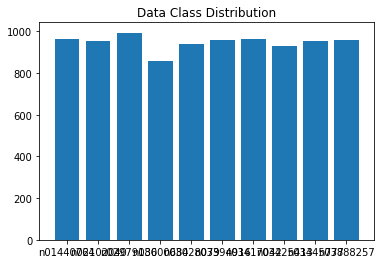

In [0]:
labels=[]
for file_ in files:
  class_split=file_.split('/')[-2]
  try:
    labels.append(class_names.index(class_split))
  except:
    print(file_,class_split)
  #break

labels=np.array(labels)
plot_bar(labels,text='Data Class Distribution')

unique :[0 1 2 3 4 5 6 7 8 9] counts :[867 860 894 772 847 860 865 838 856 864]


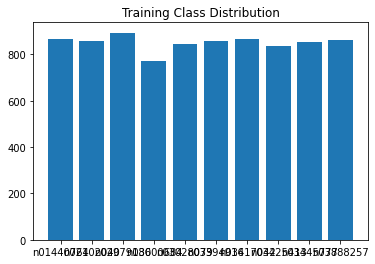

unique :[0 1 2 3 4 5 6 7 8 9] counts :[96 95 99 86 94 96 96 93 95 96]


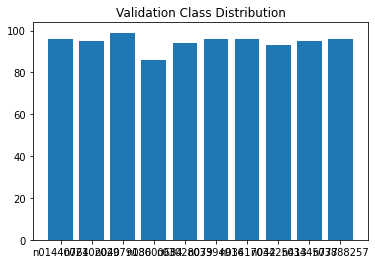

In [0]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X=files,y=labels)
for train_index, val_index in skf.split(files, labels):
  #print(train_index,val_index)
  train_files=[files[i] for i in train_index]
  train_labels=[labels[i] for i in train_index]
  val_files=[files[i] for i in val_index]
  val_labels=[labels[i] for i in val_index]

plot_bar(train_labels,text='Training Class Distribution')
plot_bar(val_labels,text='Validation Class Distribution')

In [0]:
class_idx=-2

class datagen(Sequence):
  def __init__(self,train_im_path,normalize_img,augmentations,batch_size,img_size=256,nchannels=3,shuffle=True,verbose=False):
    self.batch_size=batch_size
    self.mode='sparse'
    self.train_im_paths=train_im_path
    ## maps bw 0-1
    self.normalize_img=normalize_img
    self.img_size=img_size
    self.nchannels=nchannels
    self.shuffle=shuffle
    self.labels=class_names
    self.augmentations=augmentations
    print(self.augmentations)
    self.verbose=verbose
    self.on_epoch_end()
    print('Num images found : {}'.format(len(self.train_im_paths)))
    print('classes_found:{}'.format(self.labels))

  def __len__(self):
    return int(np.ceil(len(self.train_im_paths) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

    list_IDs_im = [self.train_im_paths[k] for k in indexes]
    
    X= self.data_generation(list_IDs_im,'rgb')
    y= self.label_generation(list_IDs_im)

    if self.augmentations==None:
      if self.normalize_img:
        return self.normalize(X),y
      return X,y
    else:
      im= []
      for x in X:
        augmented = self.augmentations(image=x)
        im.append(augmented['image'])
      if self.normalize_img:
        return self.normalize(im),y
      else:
        return np.array(im),y
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.train_im_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def data_generation(self,list_IDs,color_mode):

    X = np.empty((len(list_IDs),self.img_size,self.img_size, self.nchannels))

    for count,i in enumerate(list_IDs):
      try:
        x=img_to_array(load_img(path=i,target_size=(self.img_size,self.img_size),color_mode=color_mode))
      except :
        print(i)
      x=np.expand_dims(x,axis=0)
      X[count]=x
    return np.uint8(X)

  def label_generation(self,list_IDs):
    one_hot=np.zeros((len(list_IDs),len(self.labels)))
    for count,i in enumerate(list_IDs):
      id_=i.split('/')[class_idx]
      id_=id_.split('_')[0]
      #if self.verbose:
      #print(i,id_)
      if id_ in self.labels:
        idx=self.labels.index(id_)
        one_hot[count][idx]=1.0
      else:
        raise ValueError
    if self.mode=='sparse':
      return np.argmax(one_hot,axis=1)
    if self.mode=='onehot':
      return one_hot

  
  def normalize(self,x):
    return np.array(x,dtype=np.float32)/255.0

In [0]:
AUGMENTATIONS_TRAIN= albu.Compose([
        albu.Flip(),
        albu.RandomBrightnessContrast(),            
        albu.OneOf([
            albu.IAAAdditiveGaussianNoise(),
            albu.GaussNoise(),
        ], p=0.2),
        albu.OneOf([
            albu.MotionBlur(p=.2),
            albu.MedianBlur(blur_limit=3, p=0.1),
            albu.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        albu.ShiftScaleRotate(shift_limit=0.0001, scale_limit=0.001, rotate_limit=45,border_mode=0),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
            albu.ElasticTransform(p=0.3)
        ], p=0.3),

    ], p=1.0)
AUGMENTATIONS_VAL=None

In [0]:
gen=datagen(train_files,False,None,batch_size,width,3,False)
aug_gen=datagen(train_files,False,AUGMENTATIONS_TRAIN,batch_size,width,3,True,False)
valgen=datagen(val_files,False,AUGMENTATIONS_VAL,batch_size,width,3,True,False)

None
Num images found : 8523
classes_found:['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Num images found : 8523
classes_found:['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
None
Num images found : 946
classes_found:['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


index: 8
(64, 224, 224, 3) (64,)


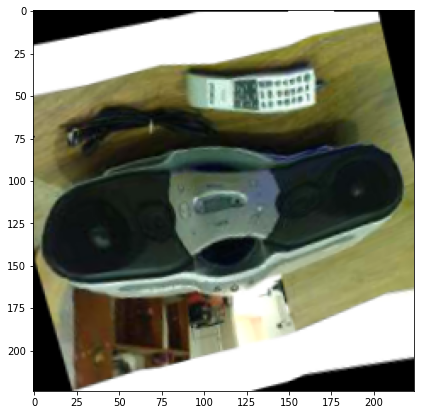

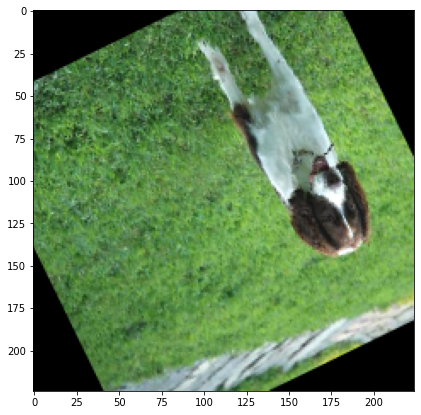

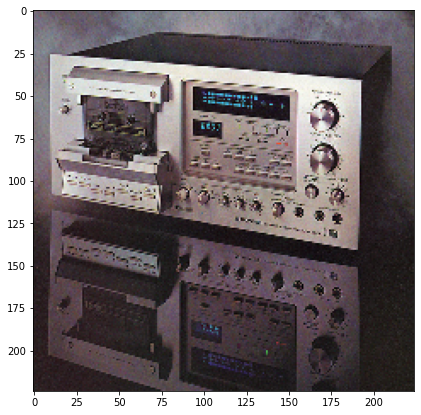

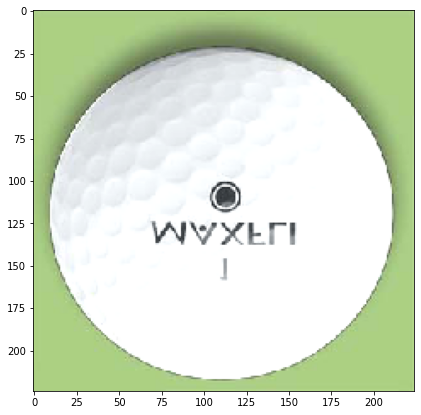

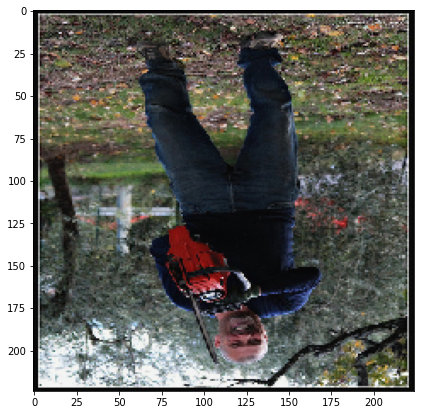

In [0]:
id=np.random.randint(0,len(aug_gen))
print('index:',id)
augimg,auglab=aug_gen[id]
print(augimg.shape,auglab.shape)

for i in range(len(augimg)):
  fig,ax=plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(7,7))
  #ax[0].title.set_text(str(lab[i])+':{}'.format(gen.labels[np.argmax(lab[i])]))
  #ax[0].imshow(img[i])
  #ax.title.set_text(str(auglab[i])+':{}'.format(aug_gen.labels[auglab[i]]))
  ax.imshow(augimg[i])
  if i==4:
    break

index: 7
(64, 128, 128, 3) (64,) uint8 int64


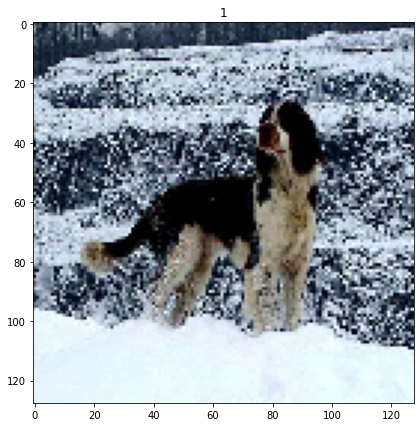

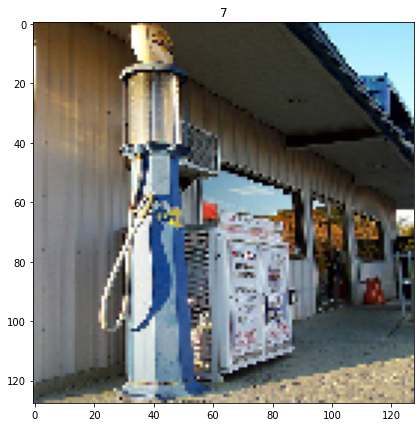

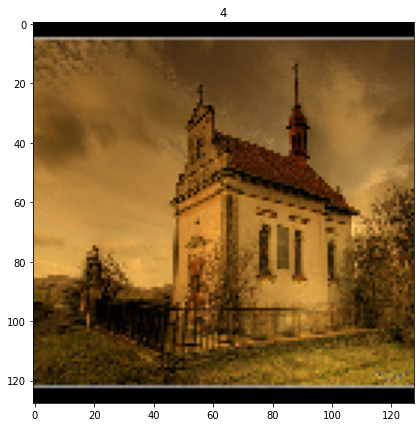

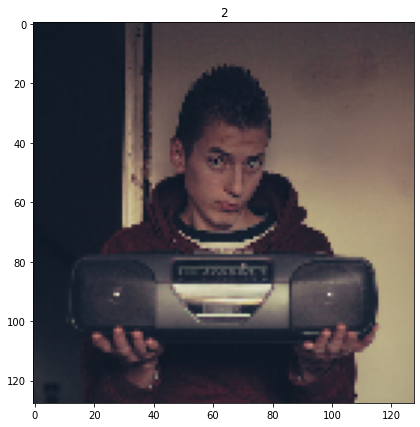

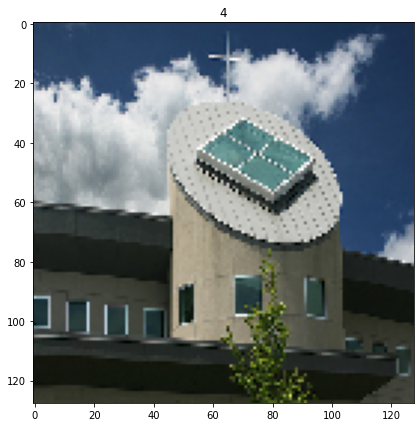

In [0]:
id=np.random.randint(0,len(valgen))
print('index:',id)
img,lab=valgen[id]
print(img.shape,lab.shape,img.dtype,lab.dtype)
for i in range(len(img)):
  fig,ax=plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(7,7))
  ax.title.set_text(str(lab[i]))
  #ax.title.set_text(str(lab[i])+':{}'.format(valgen.labels[lab[i]]))
  ax.imshow(img[i])
  if i==4:
    break

Build encoder network Resnet50 backbone without imagenet weights with outputs as 2048D embeddings. The 2048D embeddings is mapped into 128D or 256D for further dimensionality reduction analysis. These reduced embeddings holds the contrastive features of each class learned from contrastive loss function.

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input(size)
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(256, activation="relu"),
		UnitNormLayer()
	])

	return projector


In [0]:
K.clear_session()
optimizer = tf.keras.optimizers.Adam()
encoder_r = encoder_net()
projector_z = projector_net()


@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.074
Epoch: 1 Loss: 0.074
Epoch: 2 Loss: 0.073
Epoch: 3 Loss: 0.072
Epoch: 4 Loss: 0.072


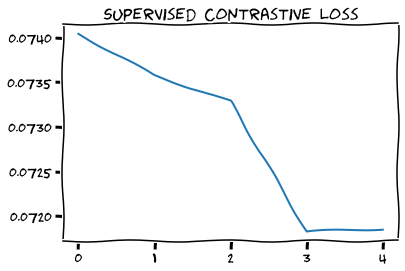

In [0]:
aug_gen.mode='sparse'
K.set_value(optimizer.lr,7.5e-4)
EPOCHS = 5
LOG_EVERY = 1
train_loss_results = []

start = time.time()
for epoch in (range(EPOCHS)):	
  epoch_loss_avg = tf.keras.metrics.Mean()
  for step in (range(len(aug_gen))):
      images,labels=aug_gen[step]
      loss = train_step(images, labels)
      epoch_loss_avg.update_state(loss) 
  train_loss_results.append(epoch_loss_avg.result())
  if epoch % LOG_EVERY == 0:
    print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
end = time.time()

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

In [0]:
#encoder_r=load_model('encoder_i5.h5',custom_objects={'UnitNormLayer':UnitNormLayer})
#projector_z=load_model('projector_i5.h5',custom_objects={'UnitNormLayer':UnitNormLayer})

Let's plot the 256D embeddings of validation data with tSNE. The more the space between clusters better the robustness of the resulting classifier. 

In [0]:
aug_gen.mode='sparse'
num_samples=946
BS=batch_size
encoded_vector=np.zeros(shape=(num_samples,2048))
projected_vector=np.zeros(shape=(num_samples,256))
label_vector=np.zeros(shape=(num_samples,))
count=0
for step in range(len(valgen)):
  images,labels=valgen[step]
  if len(images)==BS:
    encoded_vector[count:count+BS,:]=encoder_r.predict(images)
    projected_vector[count:count+BS,:]=projector_z.predict(encoded_vector[count:count+BS,:])
    label_vector[count:count+BS]=labels
  else:
    encoded_vector[count:count+len(images),:]=encoder_r.predict(images)
    projected_vector[count:count+len(images),:]=projector_z.predict(encoded_vector[count:count+len(images),:])
    label_vector[count:count+len(images)]=labels
  count+=BS
  

In [0]:
def plot_embeddings(emb,labels):
  tl=TSNE()
  embedding=tl.fit_transform(emb)
  fig = plt.figure(figsize = (10, 10))
  sns.scatterplot(embedding[:,0], embedding[:,1], hue=labels)
  plt.show()
  plt.clf()

In [0]:
np.unique(label_vector,return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([96, 95, 99, 86, 94, 96, 96, 93, 95, 96]))

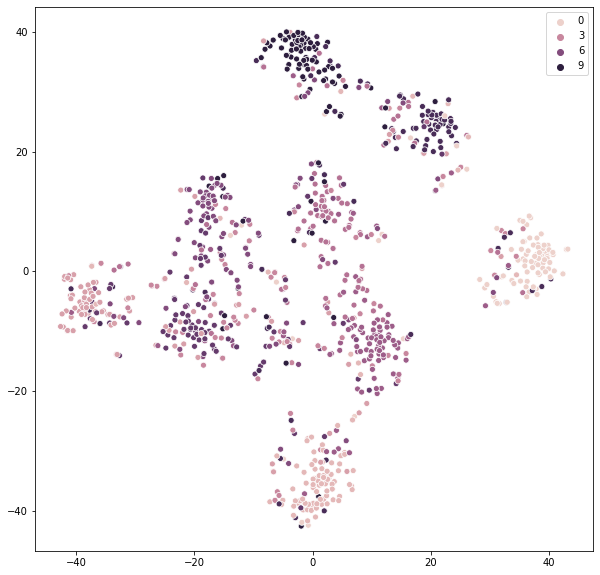

<Figure size 432x288 with 0 Axes>

In [0]:
plot_embeddings(projected_vector,label_vector)

Now we can add a simple 10 classes softmax classifier with cross entropy based loss on top of this 256D embeddings to classify the above clusters.

In [0]:
def supervised_contrastive_net(encoder,projector,num_classes,act):
  encoder.trainable=False
  projector.trainable=False
  inputs=encoder.input
  x=encoder.layers[-1].output
  x=projector(x)
  x=Dense(num_classes,act)(x)
  return Model(inputs,x)

In [0]:
K.clear_session()
#encoder_r=load_model('encoder_i5.h5',custom_objects={'UnitNormLayer':UnitNormLayer})
#projector_z=load_model('projector_i5.h5',custom_objects={'UnitNormLayer':UnitNormLayer})
classifier=supervised_contrastive_net(encoder_r,projector_z,num_classes=10,act='softmax')
cls_optimizer = tf.keras.optimizers.Adam()
classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
unit_norm_layer (UnitNormLay (None, 2048)              0         
_________________________________________________________________
sequential (Sequential)      (None, 256)               524544    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 24,114,826
Trainable params: 2,570
Non-trainable params: 24,112,256
_____________________________________________

In [0]:
aug_gen.mode='onehot'
valgen.mode='onehot'
classifier.compile(loss='categorical_crossentropy',optimizer=cls_optimizer,metrics=['categorical_accuracy'])

In [0]:
INITIAL_EPOCH=0
EPOCHS = 10
#K.set_value(classifier.optimizer.lr,7.5e-4)
classifier.fit(aug_gen,validation_data=valgen,initial_epoch=INITIAL_EPOCH,
               epochs=EPOCHS)

Epoch 1/10
134/134 [==============================] - 214s 2s/step - loss: 2.1695 - categorical_accuracy: 0.4551 - val_loss: 2.0425 - val_categorical_accuracy: 0.6089
Epoch 2/10
134/134 [==============================] - 214s 2s/step - loss: 1.9320 - categorical_accuracy: 0.6278 - val_loss: 1.8277 - val_categorical_accuracy: 0.6258
Epoch 3/10
134/134 [==============================] - 211s 2s/step - loss: 1.7337 - categorical_accuracy: 0.6367 - val_loss: 1.6520 - val_categorical_accuracy: 0.6332
Epoch 4/10
134/134 [==============================] - 209s 2s/step - loss: 1.5741 - categorical_accuracy: 0.6438 - val_loss: 1.5145 - val_categorical_accuracy: 0.6332
Epoch 5/10
134/134 [==============================] - 199s 1s/step - loss: 1.4511 - categorical_accuracy: 0.6482 - val_loss: 1.4097 - val_categorical_accuracy: 0.6374
Epoch 6/10
134/134 [==============================] - 201s 2s/step - loss: 1.3517 - categorical_accuracy: 0.6553 - val_loss: 1.3295 - val_categorical_accuracy: 0.644

In [0]:
### check whether the model is serialized and loaded properly due to custom objects 
encoder_r.save('encoder_imagenette.h5')
projector_z.save('projector_imagenette.h5')
classifier.save('contrastive_supervised_imagenette.h5')
#load_model('encoder_imagenette.h5',custom_objects={'UnitNormLayer':UnitNormLayer})
#load_model('projector_imagenette.h5',custom_objects={'UnitNormLayer':UnitNormLayer})

We can observe that the pretraining with contrastive model produces a smooth validation accuracy curve. Let's train a normal fully supervised classifier with same ResNet50(scratch) and compare the results.

In [0]:
K.clear_session()
base_model=tf.keras.applications.ResNet50(weights=None, include_top=False)
inputs=base_model.inputs
x=GlobalAveragePooling2D()(base_model.layers[-1].output)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
outputs=tf.keras.layers.Dense(10, activation='softmax')(x)
model=Model(inputs,outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])

In [0]:
#K.set_value(model.optimizer.lr,8e-4)
aug_gen.mode='onehot'
valgen.mode='onehot'
model.fit_generator(aug_gen,steps_per_epoch=len(aug_gen),epochs=20,validation_data=valgen,validation_steps=len(valgen))

Epoch 1/20
134/134 [==============================] - 264s 2s/step - loss: 2.0171 - categorical_accuracy: 0.2999 - val_loss: 2.4291 - val_categorical_accuracy: 0.1512
Epoch 2/20
134/134 [==============================] - 271s 2s/step - loss: 1.7048 - categorical_accuracy: 0.4183 - val_loss: 3.4678 - val_categorical_accuracy: 0.1818
Epoch 3/20
134/134 [==============================] - 265s 2s/step - loss: 1.5294 - categorical_accuracy: 0.4823 - val_loss: 3.7398 - val_categorical_accuracy: 0.2146
Epoch 4/20
134/134 [==============================] - 260s 2s/step - loss: 1.4019 - categorical_accuracy: 0.5346 - val_loss: 1.9895 - val_categorical_accuracy: 0.3520
Epoch 5/20
134/134 [==============================] - 262s 2s/step - loss: 1.3139 - categorical_accuracy: 0.5655 - val_loss: 2.2517 - val_categorical_accuracy: 0.4524
Epoch 6/20
134/134 [==============================] - 258s 2s/step - loss: 1.2384 - categorical_accuracy: 0.5885 - val_loss: 1.9378 - val_categorical_accuracy: 0.408

We can observe the validation accuracy curve to be erratic with a top accuracy of 63% in 15th epoch whereas the supervised contrastive model achieves 64% in 6th epoch and was continously increasing. Let's plot the 256D embeddings to visualize the feature representation of this fully supervised cross-entropy based model.

In [0]:
proj_inputs=model.inputs
proj_outputs=model.layers[-2].output
projecter_model=Model(proj_inputs,proj_outputs)
projecter_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
num_samples=946
BS=batch_size
valgen.mode='sparse'
sup_projected_vector=np.zeros(shape=(num_samples,256))
sup_label_vector=np.zeros(shape=(num_samples,))
count=0
for step in range(len(valgen)):
  images,labels=valgen[step]
  if len(images)==BS:
    sup_projected_vector[count:count+BS,:]=projecter_model.predict(images)
    sup_label_vector[count:count+BS]=labels
  else:
    sup_projected_vector[count:count+len(images),:]=projecter_model.predict(images)
    sup_label_vector[count:count+len(images)]=labels
  count+=BS
  

In [0]:
np.unique(sup_label_vector,return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([96, 95, 99, 86, 94, 96, 96, 93, 95, 96]))

We can see the features are tightly knit representing that the classifier may have a hard time to classify samples across the clusters(classes) resulting in a reduced robustness when compared to contrastive learning model.

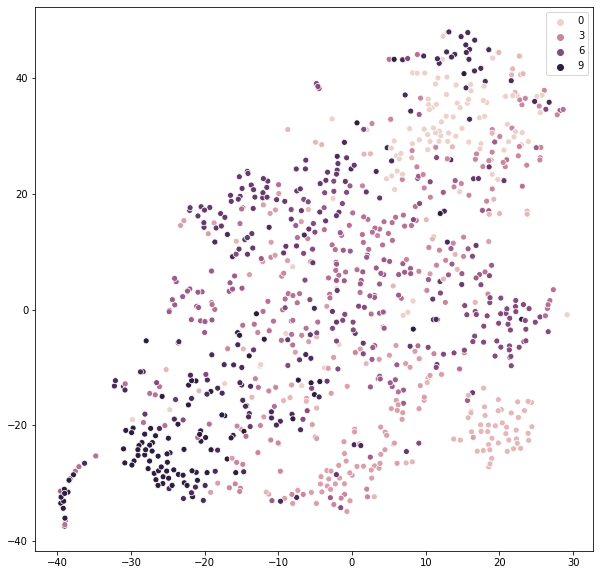

<Figure size 432x288 with 0 Axes>

In [0]:
plot_embeddings(sup_projected_vector,sup_label_vector)

In [0]:
model.save('supervised_imagenette.h5')